In [1]:
# Import the relevant libraries
from scipy import optimize
from scipy import signal
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import timedelta
import xarray as xr
import dask
import dask.array as da
import glob
import os
import time

# import from dictionary
from dictionaries import *

{'H_dam': 161, 'reservoir_area': 13000000.0, 'kappa': 6500000.0, 'catchment_area': 254000000.0, 'H_max': 48.3, 'H_min': 64.4, 'low_tau': 7776000, 'high_tau': 31104000, 'tau': 15552000, 'W_max': 67.29038065843622, 'W_min': 6.729038065843622, 'R_max': 13.458076131687244, 'G_max': 153, 'mu': 0.015691702302558362, 'sigma': 0.9, 'start_date': '2017-06-01', 'end_date': '2017-09-30', 'dt': 86400, 'path': 'C:\\Users\\Ben Hutchins\\OneDrive - University of Reading\\Documents\\GitHub\\MTMG50-Technical-Assignment\\tokuyama_daymean.nc', 'task': 'Q2', 'fig_name': '2017-06-01-2017-09-30_optimization_Q2_small_range.png'}
{'H_dam': 161, 'reservoir_area': 13000000.0, 'kappa': 6500000.0, 'catchment_area': 254000000.0, 'H_max': 128.8, 'H_min': 16.1, 'low_tau': 7776000, 'high_tau': 31104000, 'tau': 15552000, 'W_max': 67.29038065843622, 'W_min': 6.729038065843622, 'R_max': 13.458076131687244, 'G_max': 153, 'mu': 0.015691702302558362, 'sigma': 0.9, 'start_date': '2017-06-01', 'end_date': '2017-09-30', 'dt':

### Original dam optimization model ###

Created by John Methven

Cell also includes running_mean function which is called by damop_model.

In [2]:
# original damop function
def damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma):
    '''
    Implementation of the dam operation model of Hirsch et al (2014).
    Input: 
    :runoffarr  - input time series for runoff data
    :dt         - runoff accumulation interval per record
    :catcharea  - catchment area for the dam
    :kappa      - parameter relating reservoir depth to volume
    :hmax       - maximum water head (constraint on optimization)
    :hmin       - minimum water head
    :wmax       - maximum flow rate through turbines
    :wmin       - minimum flow rate to maintain some power generation
    :rmax       - maximum relief flow rate, bypassing turbines in flood
    :sigma      - operational efficiency of power generation by dam
    Output: 
    :inflow     - input time series for inflow to reservoir  
    :x          - output time series for water head at dam
    :w          - output solution for optimum flow rate through turbines
    :r          - output solution for relief flow rate
    :gout       - value of time integrated generation for optimum solution (MW-days)
    '''       
    print()
    print('damop_model has been called with the constraints:')
    print('wmax = ',wmax,'   wmin = ',wmin,'   hmax = ',hmax,'   hmin = ',hmin)
    #
    # Convert runoff data from units of m to an equivalent inflow in m^3 s^-1
    # Assume that the same runoff rate applies to the entire catchment area for dam
    #
    runoffave = np.mean(runoffarr)
    inflow = catcharea*runoffarr/dt
    n = len(inflow)
    inmax = max(inflow)
    #
    # Set parameter used to control computational mode using filter similar to Robert-Asselin
    # Recommend 0 because filter introduces an offset of W relative to I in optimization.
    #
    alpha = 0.0
    #
    # Apply running mean to the inflow data if required for smoother solution 
    # to the optimisation. Averaging window length = nwin.
    #
    nwin = 3
    inflow = running_mean(inflow, nwin)
    #
    # Scale mu so that the sum of generation over time points is approx one.
    # This gives a better numerical solution in the optimisation for max generation
    # by reducing numerical truncation error in the calculation.
    #
    mu = 1.0/(n*sigma*wmax*hmax)
    #
    # The dam management optimization model is set up in the mathematical form of a 
    # quadratic programming problem.
    # The only input time series is the inflow to the reservoir.
    # The model solves for the water head at the dam maximizing power generation.
    # This then gives the flow rate through the turbines.
    # However, contraints are applied on maximum and minimum water level 
    # and maximum/minimum flow rate through the turbines.
    #
    # The equation for generation can be written in the form
    # 
    # G = 0.5*H^T P H + q^T H
    #
    # where H is the head time series we are solving for (a 1-D array) and 
    # P is a matrix and q is also a 1-D time series (scaled inflow).
    # The notation ^T means the transpose of the matrix. 
    # Quadratic programming aims to minimize -G which is equivalent to max(G).
    #
    q = -mu*sigma*inflow
    umat = np.zeros((n, n))
    inmat = np.zeros((n, n))
    cmat = np.zeros((n, n))
    for i in range(n):
        umat[i, i] = 1
        inmat[i, i] = inflow[i]

    for j in range(n-2):
        i = j+1
        cmat[i, i-1] = -1 + 0.5*alpha
        cmat[i, i]   = -alpha
        cmat[i, i+1] = 1 + 0.5*alpha
    
    pscal = mu*sigma*(kappa/dt)*cmat
    wscal = -0.5*(kappa/dt)*cmat
    #
    # Set constraints on the water head at the dam: hmin <= h <= hmax
    # Optimization requires that constraints actually need to be applied in form:
    # Amat x <= b  (where in this problem the vector x is head time series, h).
    # For Amat x >= b it is necessary to re-arrange to -Amat x <= -b.
    # Therefore to apply hmin <= h <= hmax, the matrix Amat is the unit matrix.
    #
    hscal = umat
    hmaxcons = np.ones(n)*hmax
    hmincons = np.ones(n)*hmin    
    #
    # Set constraints on the flow rate 
    # based on the parameters Wmax, Rmax and Wmin.
    # The form of the contraints means that it must be applied to range of W*h:
    # Wmin*hmin <= W*h <= (Wmax+Rmax)*hmax
    #
    gscal = wscal + inmat
    gmaxcons = np.zeros(n)
    gmincons = np.zeros(n)
    for i in range(n):
        gmaxcons[i] = (wmax+rmax)*hmax
        gmincons[i] = wmin*0.5*(hmin+hmax)
    #
    # Construct a single matrix describing Amat and vector for constraint values b
    # in the form required by optimize.minimize
    #
    vmat = np.concatenate((gscal, -gscal, hscal, -hscal), axis=0)
    vcons = np.concatenate((gmaxcons, -gmincons, hmaxcons, -hmincons))
    
    print('Now apply quadratic minimization technique')
    
    def gen(x, sign=1.):
        return sign * (0.5*np.dot(x.T, np.dot(pscal, x)) + np.dot(q.T, x))
    
    def jac(x, sign=1.):
        return sign * (np.dot(x.T, pscal) + q.T)
    
    cons = {'type':'ineq',
            'fun':lambda x: vcons - np.dot(vmat, x),
            'jac':lambda x: -vmat}
    
    opt = {'disp':True, 'maxiter':100, 'ftol':1e-08}

    #
    # Obtain solution by minimization nouter times. Smooth the input first guess 
    # and results for head, h, which removes noise and any numerical instability in 
    # optimal solution for the flow rate time series, W.
    # Note that the minimize method does not always find a solution consistent 
    # with the contraints imposed (depending on the first guess data) and these
    # failed attempts are not included in the average solution.
    #
    nouter = 3
    istsuccess = 1
    ic = -1
    afac = 0.5
    xinit = hmax*(afac + 0.1*np.random.randn(n))
    nwin = min([41, 2*round(0.2*n)+1])
    print('running mean window length, nwin = ',nwin)
    xinit = running_mean(xinit, nwin)
    
    for io in range(nouter):
    #while istsuccess == 1:
        #
        # First guess values for x (water head).
        # Random variation on top of constant level.
        # Smooth to reduce 2-grid noise in input data.
        #
        ic = ic+1
        res_cons = optimize.minimize(gen, xinit, jac=jac, constraints=cons,
                                 method='SLSQP', options=opt)
        xup = res_cons['x']
        fup = res_cons['fun']  
        stexit = res_cons['status']
    
        if stexit != 4:
            if istsuccess == 1:
                x = xup
                x = running_mean(x, nwin)
                xinit = x
                f = fup
                print('Constrained optimization')
                print(res_cons)
                print('iter ',ic,' f = ',f)
                istsuccess = 0
            else:
                if (fup/f) < 2:
                    afac = float(ic+1)/nouter
                    x = afac*x + (1-afac)*xup
                    x = running_mean(x, nwin)
                    xinit = x
                    f = afac*f + (1-afac)*fup
                    print('iter ',ic,' f = ',f)
        if ic == nouter:
            print(nouter,' outer iterations finished without reaching result')
            istsuccess = 1
    # end outer loop
    
    #
    # Optimisation returns the head in variable x
    # Total flow rate ft = W+R is calculated from head and known inflow rate
    # Total flow is diverted into relief flow when it exceeds Wmax (and Rmax > 0)
    #
    ft = np.dot(wscal, x) + inflow
    w = np.copy(ft)
    r = np.zeros(n)
    excessflow = np.where(ft > wmax)
    if rmax > 0:
        w[excessflow] = wmax
        r[excessflow] = ft[excessflow]-wmax
    
    gout = -f
    
    return inflow, x, w, r, gout

# running mean function
def running_mean(xarr, nwin):
    '''
    Apply running mean filter through array
    Inputs:
        xarr    - array to filter
        nwin    - number of points in the filter window (odd number expected)
    Output:
        xfilt   - same length as xarr after application of filter
    '''
    n = len(xarr)
    xfilt = np.copy(xarr)
    ist = int(nwin/2)
    xconv = np.convolve(xarr, np.ones(nwin),'valid')/nwin
    nconv = len(xconv)
    xfilt[ist:n-ist] = xconv[:]
    xfilt[0:ist] = xconv[0]
    xfilt[n-ist:n] = xconv[nconv-1]
    
    return xfilt

### Updated dam optimization model ###

Used to call up damop_model with dictionaries containing values

Includes optional plotting call dependent on task name (e.g. Q1, Q2)

In [3]:
# updated dam operation model
def damop_model_UPDATED(params):
    '''
    Implementation of the dam operation model of Hirsch et al (2014).
    
    Inputs:
    params  - list of parameters for the model

    Outputs:
    inflow   - inflow rate to the dam (m^3 s^-1)
    x - head in the reservoir (m)
    w - flow rate through the dam (m^3 s^-1)
    r - flow rate through the relief channel (m^3 s^-1)
    gout - objective function value (negative of the total flow rate)                     
    '''
    # first import the constants from the dictionary
    catcharea = params['catchment_area'] # the area of the catchment (m^2)
    kappa = params['kappa'] # proportionality constant between resv. volume and head
    hmax = params['H_max'] # maximum safe water height in the reservoir (m)
    hmin = params['H_min'] # minimum safe water height in the reservoir (m)
    wmax = params['W_max'] # maximum safe flow rate through the dam (m^3 s^-1)
    wmin = params['W_min'] # minimum flow rate through the dam (m^3 s^-1)
    rmax = params['R_max'] # maximum flow rate through the relief channel avoiding turbines (m^3 s^-1)
    sigma = params['sigma'] # efficiency of power generation (proportion)

    # import the task flag and fig name
    task = params['task']
    fig_name = params['fig_name']

    # now we want to import the runoff data
    # first import the path for the netcdf point file
    path = params['path']
    # now import the data
    f = Dataset(path, 'r')
    # import runoff and time data
    # this part was updated with the help of james to make//
    # the model run faster lol
    # for some reason netcdf file is in four hourly chunks?gi
    # set the runoffarr and time arrays
    runoffarr = f.variables['ro'][:,0,0]
    time = f.variables['time'][:]
     # close the file
    f.close()

    # convert the time to a datetime object
    start = datetime.datetime(1900, 1, 1, 0, 0, 0) # hours since 1900-01-01 00:00:00
    time = [start + datetime.timedelta(hours=t) for t in time]

    # create a dataframe to store the data
    df = pd.DataFrame({'time':time, 'runoff':runoffarr})

    # we want to constrain the model to only run for a certain period of time
    # first we need to import the start and end dates
    # these should be in the format yyyy-mm-dd
    start_date = params['start_date']
    end_date = params['end_date']

    # define the condition which constrains the data
    condition = (df['time'].between(start_date, end_date))
    constrained_df = df.loc[condition]
    # now we want to set the constrained data as arrays
    runoffarr = constrained_df['runoff'].to_numpy()
    timearr = constrained_df['time'].to_numpy()

    # now we want to set the timestep for converting the runoff data below
    dt = params['dt'] # runoff accumulation interval per record (s)

    print()
    print('damop_model has been called with the constraints:')
    print('wmax = ',wmax,'   wmin = ',wmin,'   hmax = ',hmax,'   hmin = ',hmin)
    #
    # Convert runoff data from units of m to an equivalent inflow in m^3 s^-1
    # Assume that the same runoff rate applies to the entire catchment area for dam
    #
    runoffave = np.mean(runoffarr)
    inflow = catcharea*runoffarr/dt
    n = len(inflow)
    inmax = max(inflow)
    #
    # Set parameter used to control computational mode using filter similar to Robert-Asselin
    # Recommend 0 because filter introduces an offset of W relative to I in optimization.
    #
    alpha = 0.0
    #
    # Apply running mean to the inflow data if required for smoother solution 
    # to the optimisation. Averaging window length = nwin.
    #
    nwin = 3
    inflow = running_mean(inflow, nwin)
    #
    # Scale mu so that the sum of generation over time points is approx one.
    # This gives a better numerical solution in the optimisation for max generation
    # by reducing numerical truncation error in the calculation.
    #
    mu = 1.0/(n*sigma*wmax*hmax)
    #
    # The dam management optimization model is set up in the mathematical form of a 
    # quadratic programming problem.
    # The only input time series is the inflow to the reservoir.
    # The model solves for the water head at the dam maximizing power generation.
    # This then gives the flow rate through the turbines.
    # However, contraints are applied on maximum and minimum water level 
    # and maximum/minimum flow rate through the turbines.
    #
    # The equation for generation can be written in the form
    # 
    # G = 0.5*H^T P H + q^T H
    #
    # where H is the head time series we are solving for (a 1-D array) and 
    # P is a matrix and q is also a 1-D time series (scaled inflow).
    # The notation ^T means the transpose of the matrix. 
    # Quadratic programming aims to minimize -G which is equivalent to max(G).
    #
    q = -mu*sigma*inflow
    umat = np.zeros((n, n))
    inmat = np.zeros((n, n))
    cmat = np.zeros((n, n))
    for i in range(n):
        umat[i, i] = 1
        inmat[i, i] = inflow[i]

    for j in range(n-2):
        i = j+1
        cmat[i, i-1] = -1 + 0.5*alpha
        cmat[i, i]   = -alpha
        cmat[i, i+1] = 1 + 0.5*alpha
    
    pscal = mu*sigma*(kappa/dt)*cmat
    wscal = -0.5*(kappa/dt)*cmat
    #
    # Set constraints on the water head at the dam: hmin <= h <= hmax
    # Optimization requires that constraints actually need to be applied in form:
    # Amat x <= b  (where in this problem the vector x is head time series, h).
    # For Amat x >= b it is necessary to re-arrange to -Amat x <= -b.
    # Therefore to apply hmin <= h <= hmax, the matrix Amat is the unit matrix.
    #
    hscal = umat
    hmaxcons = np.ones(n)*hmax
    hmincons = np.ones(n)*hmin    
    #
    # Set constraints on the flow rate 
    # based on the parameters Wmax, Rmax and Wmin.
    # The form of the contraints means that it must be applied to range of W*h:
    # Wmin*hmin <= W*h <= (Wmax+Rmax)*hmax
    #
    gscal = wscal + inmat
    gmaxcons = np.zeros(n)
    gmincons = np.zeros(n)
    for i in range(n):
        gmaxcons[i] = (wmax+rmax)*hmax
        gmincons[i] = wmin*0.5*(hmin+hmax)
    #
    # Construct a single matrix describing Amat and vector for constraint values b
    # in the form required by optimize.minimize
    #
    vmat = np.concatenate((gscal, -gscal, hscal, -hscal), axis=0)
    vcons = np.concatenate((gmaxcons, -gmincons, hmaxcons, -hmincons))
    
    print('Now apply quadratic minimization technique')
    
    def gen(x, sign=1.):
        return sign * (0.5*np.dot(x.T, np.dot(pscal, x)) + np.dot(q.T, x))
    
    def jac(x, sign=1.):
        return sign * (np.dot(x.T, pscal) + q.T)
    
    cons = {'type':'ineq',
            'fun':lambda x: vcons - np.dot(vmat, x),
            'jac':lambda x: -vmat}
    
    opt = {'disp':True, 'maxiter':100, 'ftol':1e-08}

    #
    # Obtain solution by minimization nouter times. Smooth the input first guess 
    # and results for head, h, which removes noise and any numerical instability in 
    # optimal solution for the flow rate time series, W.
    # Note that the minimize method does not always find a solution consistent 
    # with the contraints imposed (depending on the first guess data) and these
    # failed attempts are not included in the average solution.
    #
    nouter = 3
    istsuccess = 1
    ic = -1
    afac = 0.5
    xinit = hmax*(afac + 0.1*np.random.randn(n))
    nwin = min([41, 2*round(0.2*n)+1])
    print('running mean window length, nwin = ',nwin)
    xinit = running_mean(xinit, nwin)
    
    for io in range(nouter):
    #while istsuccess == 1:
        #
        # First guess values for x (water head).
        # Random variation on top of constant level.
        # Smooth to reduce 2-grid noise in input data.
        #
        ic = ic+1
        res_cons = optimize.minimize(gen, xinit, jac=jac, constraints=cons,
                                 method='SLSQP', options=opt)
        xup = res_cons['x']
        fup = res_cons['fun']  
        stexit = res_cons['status']
    
        if stexit != 4:
            if istsuccess == 1:
                x = xup
                x = running_mean(x, nwin)
                xinit = x
                f = fup
                print('Constrained optimization')
                print(res_cons)
                print('iter ',ic,' f = ',f)
                istsuccess = 0
            else:
                if (fup/f) < 2:
                    afac = float(ic+1)/nouter
                    x = afac*x + (1-afac)*xup
                    x = running_mean(x, nwin)
                    xinit = x
                    f = afac*f + (1-afac)*fup
                    print('iter ',ic,' f = ',f)
        if ic == nouter:
            print(nouter,' outer iterations finished without reaching result')
            istsuccess = 1
    # end outer loop
    
    #
    # Optimisation returns the head in variable x
    # Total flow rate ft = W+R is calculated from head and known inflow rate
    # Total flow is diverted into relief flow when it exceeds Wmax (and Rmax > 0)
    #
    ft = np.dot(wscal, x) + inflow
    w = np.copy(ft)
    r = np.zeros(n)
    excessflow = np.where(ft > wmax)
    if rmax > 0:
        w[excessflow] = wmax
        r[excessflow] = ft[excessflow]-wmax
    
    gout = -f

    # set up the optional plotting scripts if task = Q1 or Q2
    if task == 'Q1' or task == 'Q2':
        dam_model(start_date, end_date, inflow, x, w, r, gout, fig_name)

# also include the plotting scripts here
def dam_model(start_date, end_date, inflow, x, w, r, gout, fig_name):
    """Run the dam model and plot the results
    """
    #create a dataframe to store the results for inflow, x, w, and r
    df = pd.DataFrame({'inflow':inflow, 'x':x, 'w':w, 'r':r})
    #set up the time variable for plotting with daily intervals
    time = pd.date_range(start_date, end_date, freq='D')

    # print the characteristics of the dataframe
    print(df.describe())

    #add time to the dataframe, excluding the last value
    df['time'] = time[:-1]

    #plot the results
    #inflow, w and r are plotted on the same axis
    #x is plotted on a separate axis
    fig, ax1 = plt.subplots()
    # flow rate in m^3/s
    ax1.plot(df['time'], df['inflow'], color='blue', label = 'inflow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')')
    ax1.plot(df['time'], df['w'], color='red', label='dam flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')' )
    ax1.plot(df['time'], df['r'], color='green', label='relief flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')')
    ax1.set_xlabel('time')
    ax1.set_ylabel('flow rate (m' + r'$^3$' + 's' + r'$^{-1}$' + ')')
    ax2 = ax1.twinx()
    # set the strings on the x axis to curve
    for label in ax1.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')
    # set the opacity of the reservoir head plot to 0.5
    ax2.plot(df['time'], df['x'], color='black', label='reservoir head (m)', linestyle='--', alpha=0.5)
    ax2.set_ylabel('reservoir head (m)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # print the value of gout to 3 significant figures in the top right of the plot in a box
    plt.text(0.95, 0.88, 'gout = ' + str(round(gout, 3)), horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.title('Dam operation model results from ' + start_date + ' to ' + end_date)
    plt.show()

    #save the figure as fig_name + '.png' in the plots folder
    fig.savefig('plots/' + fig_name + '.png')
    
    return inflow, x, w, r, gout


damop_model has been called with the constraints:
wmax =  67.29038065843622    wmin =  6.729038065843622    hmax =  80.5    hmin =  32.2
Now apply quadratic minimization technique
running mean window length, nwin =  41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.37468796803851007
            Iterations: 26
            Function evaluations: 37
            Gradient evaluations: 26
Constrained optimization
     fun: -0.37468796803851007
     jac: array([-9.24916922e-03, -8.67481893e-03,  8.44097560e-04,  1.77528780e-04,
        1.73707478e-04,  1.00104842e-04,  1.07446149e-04,  1.74837356e-04,
        3.33339171e-04,  3.78681523e-04,  3.85552672e-04,  4.21630618e-04,
        4.31187989e-04,  4.82976973e-04,  4.99733866e-04,  5.57024856e-04,
        5.76827752e-04,  6.32113100e-04,  1.06496055e-04, -2.88189934e-04,
       -3.40093449e-04,  2.31084807e-04,  6.66192636e-04,  6.98774485e-04,
        7.35163278e-04,  7.83612516e-04,  8.18388708

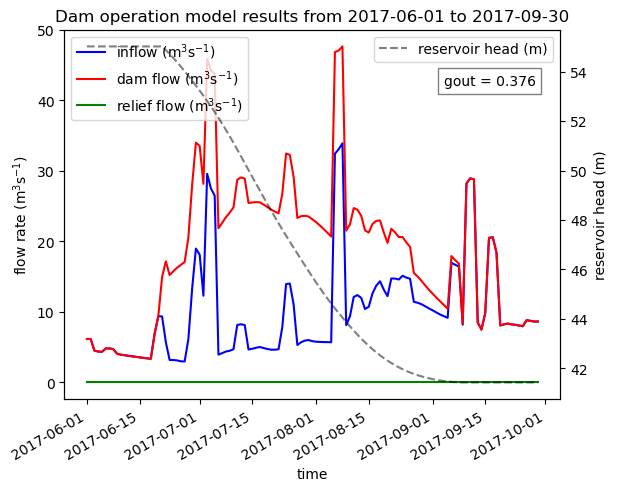

In [5]:
# test the updated damop function
# this is for questions 1 and 2
# which run with the reanalysis data

# check that parameters have loaded
#print(params_Q1a)

# run the damop function
damop_model_UPDATED(params_Q1a)

### Task 5 ###

In task 5, we optimize the dam model over the full duration of one S2S forecast - in this case that initialized on June 21, 2018.

There are 50 ensemble members.

The data for each  of the ensemble members are contained in the 20180621 folder, so we want to extract the data from this.

In [10]:
# get the current working directory
cwd = os.getcwd()

# get the path to the 20180621 folder
path = cwd + '\\20180621\\'
#print(path)

# get the list of files in the 20180621 folder
list = glob.glob(path + '*.nc')
#print(list)

# we want to load all the data from the files //
# in the 20180621 folder into a single dask array
# first we create an empty array to store the data
runoffarr_all_members = da.zeros((50, 46, 1, 1, 1))

# write a function to load the data from each file
# into our array
def load_runoff_data(list, array):
    """Load the runoff data from the list of files
      into the array.
    """

    # loop through the files in the list
    for i in range (0, len(list)):
        
        # get the file path
        file = list[i]

        # load the data from the file
        # with dask used to chunk the data
        ds = xr.open_dataset(file, chunks={'time': 1})

        # get the runoff data from the file
        runoff = ds['ro'].data

        # add the data to the array
        array[i, :, :, :, :] = runoff

    return array

# load the data from the files into the array
runoffarr_all_members = load_runoff_data(list, runoffarr_all_members)

# check that the data has loaded
# print the values for the first 5 ensemble members
#print(runoffarr_all_members[0:5, :, :, :, :].compute())

Now that we have the runoff data loaded into our runoff_all_members array, we want to run the original dam optimization model for each ensemble member (50 runs for 50 ensemble members).

In [11]:
# first we want to initialize the parameters
# for the damop function
# we will use the parameters for question 1a
dt = params_Q1a['dt']
catcharea = params_Q1a['catchment_area']
kappa = params_Q1a['kappa']
hmax = params_Q1a['H_max']
hmin = params_Q1a['H_min']
wmax = params_Q1a['W_max']
wmin = params_Q1a['W_min']
rmax = params_Q1a['R_max']
sigma = params_Q1a['sigma']

# we also need to set the start and end dates
# for the subseasonal forecast
start_date = '2018-06-22'
end_date = '2018-08-06'

# create dask arrays to store the results
# for inflow, x, w, r and gout
inflow_all_members = da.zeros((50, 46, 1))
x_all_members = da.zeros((50, 46, 1))
w_all_members = da.zeros((50, 46, 1))
r_all_members = da.zeros((50, 46, 1))
gout_all_members = da.zeros(50)

# now we want to initialize our damop delayed function
# delayed functions are used to create a graph of the
# computations that need to be done
# the graph is then executed in parallel
# this is much faster than running the damop function
# for each ensemble member
@dask.delayed
def damop_model_delayed(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma):
    inflow, x, w, r, gout = damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma)
    return inflow, x, w, r, gout

# now we want to loop through the ensemble members
# and run the damop delayed function for each member
for i in range(0, 50):
    runoffarr = runoffarr_all_members[i, :, :, :, :].flatten()

    start = time.time()

    print('starting damop model for ensemble member ' + str(i))

    inflow, x, w, r, gout = damop_model_delayed(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma).compute()

    end = time.time()

    print('damop model for ensemble member ' + str(i) + ' took ' + str(end - start) + ' seconds')

    print('estimated time remaining: ' + str((end - start) * (50 - i)) + ' seconds')

    inflow_all_members[i,:,:] = inflow.reshape(46,1)
    x_all_members[i,:,:] = x.reshape(46,1)
    w_all_members[i,:,:] = w.reshape(46,1)
    r_all_members[i,:,:] = r.reshape(46,1)
    gout_all_members[i] = gout

# check that the results have been stored in the arrays
#print(inflow_all_members.compute())
#print(x_all_members.compute())


starting damop model for ensemble member 0

damop_model has been called with the constraints:
wmax =  67.29038065843622    wmin =  6.729038065843622    hmax =  80.5    hmin =  32.2
Now apply quadratic minimization technique
running mean window length, nwin =  19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6546999868734487
            Iterations: 41
            Function evaluations: 181
            Gradient evaluations: 40
Constrained optimization
     fun: -0.6546999868734487
     jac: array([-1.79541867e-02, -1.31137853e-02,  5.45601237e-03,  2.14930596e-04,
       -5.11443365e-04, -6.54734408e-05, -7.28693471e-05, -6.90822792e-05,
        1.69076525e-04,  8.34202371e-04,  8.88239005e-04, -2.03008564e-04,
       -2.15753454e-04,  5.14187861e-04, -2.17159772e-04, -5.74282657e-04,
       -2.11647077e-04, -1.18603122e-04,  4.26294714e-04, -3.50790407e-04,
       -1.11995107e-03,  5.26951543e-06,  6.36817664e-04,  5.43397244e-04,
        1.

Now that we have output arrays for inflow, water head (x), optimum turbine flow (w), optimum relief flow (r), and the time integrated generated (gout). We want to plot these and compare to their ensemble means.

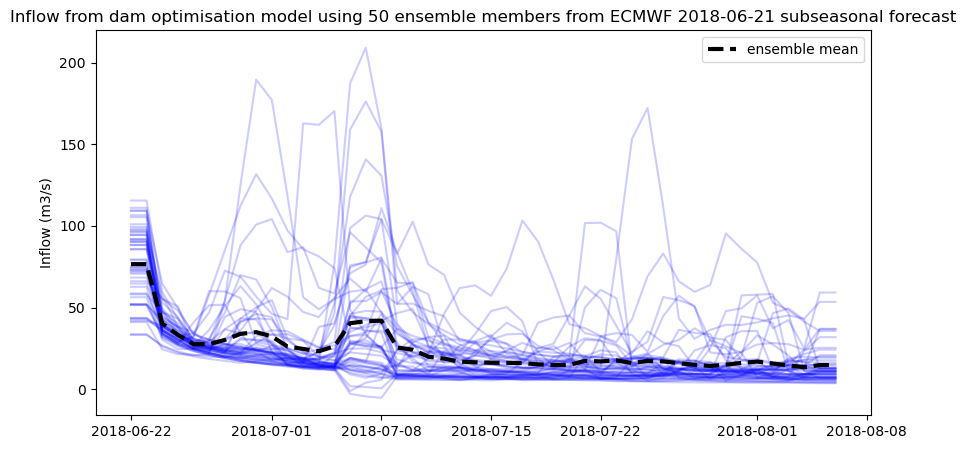

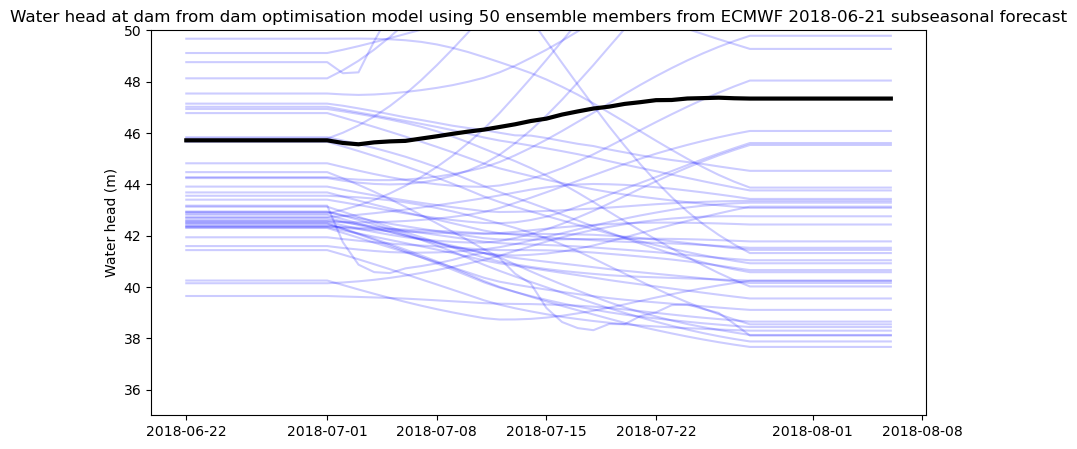

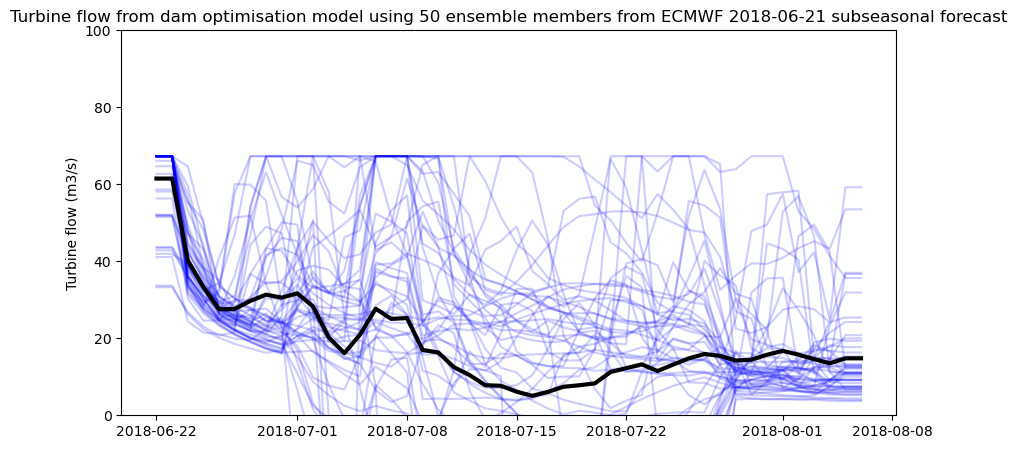

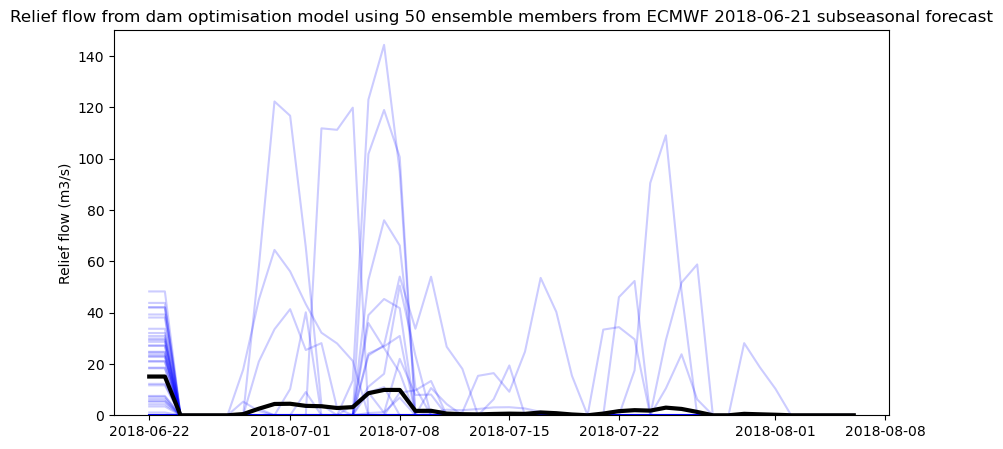

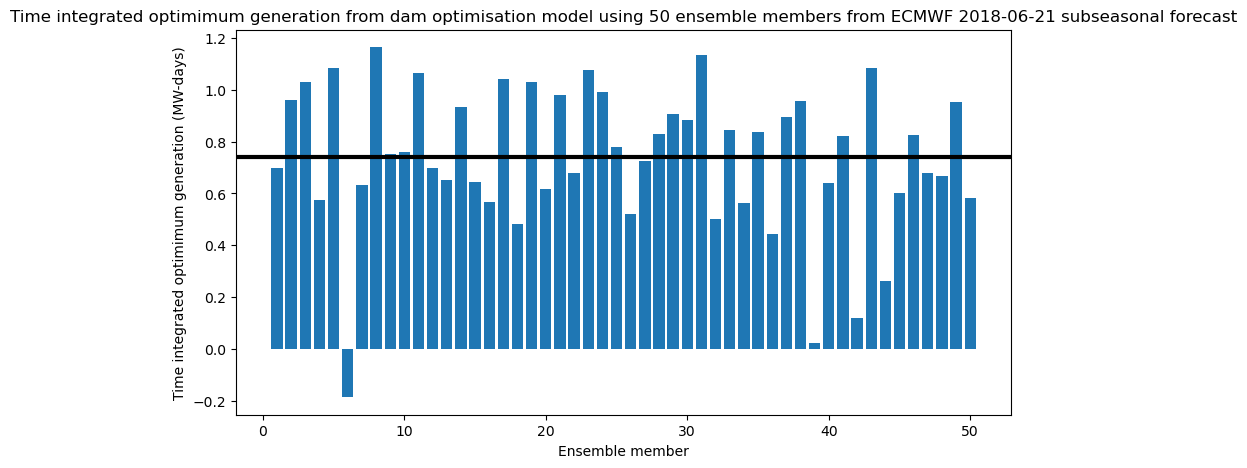

In [20]:
# define a function which will plot all of the different outputs
def plotting_ensemble(inflow_all_members, x_all_members, w_all_members, r_all_members, gout_all_members):
   
    # set up the time axis
    # between 2018-06-22 and 2018-08-06 inclusive
    # at daily intervals
    time = pd.date_range('2018-06-22', '2018-08-06', freq='D')

    # first plot the inflow_all_members
    # inflow is in m3/s and is on the y axis
    # time is on the x axis
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, inflow_all_members[i, :, 0], color='blue', alpha=0.2)

    # we only want a single label for the ensemble members
    # so we can use a proxy artist
    proxy = plt.Rectangle((0, 0), 1, 1, fc="b", alpha=0.2)
    ax.legend([proxy], ['ensemble members'])
    
    # set the y axis label
    ax.set_ylabel('Inflow (m3/s)')

    # calculate the ensemble mean and plot this
    inflow_mean = inflow_all_members.mean(axis=0)
    ax.plot(time, inflow_mean, color='black', linewidth=3, linestyle='--', label = 'ensemble mean')

    # set a title
    ax.set_title('Inflow from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # add a legend
    ax.legend()

    # save the plot
    # fig.savefig('inflow_ensemble.png', dpi=300) 

    # plot the results for x_all_members
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, x_all_members[i, :, 0], color='blue', alpha=0.2)

    # set the y axis label
    ax.set_ylabel('Water head (m)')
    # set the y lims
    ax.set_ylim(35, 50)

    # calculate the ensemble mean and plot this
    x_mean = x_all_members.mean(axis=0)
    ax.plot(time, x_mean, color='black', linewidth=3, label = 'ensemble mean')

    # set a title
    ax.set_title('Water head at dam from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # save the plot
    # fig.savefig('x_ensemble.png', dpi=300)

    # plot the results for w_all_members
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, w_all_members[i, :, 0], color='blue', alpha=0.2)

    # set the y axis label
    ax.set_ylabel('Turbine flow (m3/s)')
    # set the y lims
    ax.set_ylim(0, 100)

    # calculate the ensemble mean and plot this
    w_mean = w_all_members.mean(axis=0)
    ax.plot(time, w_mean, color='black', linewidth=3, label = 'ensemble mean')

    # set a title
    ax.set_title('Turbine flow from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # save the plot
    # fig.savefig('w_ensemble.png', dpi=300)

    # plot the results for r_all_members
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, r_all_members[i, :, 0], color='blue', alpha=0.2)

    # set the y axis label
    ax.set_ylabel('Relief flow (m3/s)')
    # set the y lims
    ax.set_ylim(0, 150)

    # calculate the ensemble mean and plot this
    r_mean = r_all_members.mean(axis=0)
    ax.plot(time, r_mean, color='black', linewidth=3)

    # set a title
    ax.set_title('Relief flow from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # save the plot
    # fig.savefig('r_ensemble.png', dpi=300)

    # plot the results for gout_all_members
    # as a bar chart
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the values of gout for each ensemble member
    # as a bar chart
    ax.bar(np.arange(1, 51), gout_all_members.compute())

    # set the y axis label
    ax.set_ylabel('Time integrated optimimum generation (MW-days)')

    # set the x axis label
    ax.set_xlabel('Ensemble member')

    # plot the mean value of gout
    # on the bar chart
    ax.axhline(gout_all_members.mean().compute(), color='black', linewidth=3, label = 'ensemble mean')

    # set a title
    ax.set_title('Time integrated optimimum generation from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # save the plot
    # fig.savefig('gout_ensemble.png', dpi=300)

# call the function to plot the results
plotting_ensemble(inflow_all_members, x_all_members, w_all_members, r_all_members, gout_all_members)

In [17]:
# print the values and shape of the gout output
print(gout_all_members)

# print the values of the gout output
print(gout_all_members.compute())

dask.array<setitem, shape=(50,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>
[ 0.69787768  0.95963738  1.03021289  0.57458935  1.08582531 -0.18700278
  0.63095568  1.16506641  0.75388007  0.75930286  1.06522336  0.69794326
  0.65060573  0.93360129  0.64416255  0.56748092  1.04238172  0.48359542
  1.03210857  0.61715051  0.98169264  0.67846134  1.07747118  0.99083002
  0.77869871  0.52203888  0.72720215  0.82858676  0.90893791  0.88335181
  1.13330208  0.50240284  0.84392469  0.56392542  0.83812964  0.44310726
  0.8965671   0.95549066  0.02209321  0.64171859  0.82095049  0.12024498
  1.08572469  0.26186677  0.60177951  0.82521848  0.67877316  0.66795502
  0.95491315  0.58202841]
